In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [18]:
# Constants
TEST_SET_SIZE = 500
VALIDATION_SET_SIZE = 1000
HOMOLOGOUS_SUPERFAMILY_CUTOFF = 500
MAX_FAMILY_SIZE = 100

### 1. Open CATH list file

In [3]:
with open('../../data/our_input/cath-domain-list-S35.txt') as f:
    raw = f.readlines()

### 2. Extract domain lengths from files that we generated (see `distance_maps_and_sequences.py`)

In [4]:
generated_domain_lengths = {}
for i in os.listdir('../../data/our_input/sequences/'):
    with open(f'../../data/our_input/sequences/{i}') as f:
        f.readline()
        generated_domain_lengths[i.split('.')[0]] = len(f.readline())

### 3. Extract Domain name, Class, Architecture, Topology, Homologous superfamily

Column 1:  CATH domain name (seven characters)\
Column 2:  Class number\
Column 3:  Architecture number\
Column 4:  Topology number\
Column 5:  Homologous superfamily number\
Column 6:  S35 sequence cluster number\
Column 7:  S60 sequence cluster number\
Column 8:  S95 sequence cluster number\
Column 9:  S100 sequence cluster number\
Column 10: S100 sequence count number\
Column 11: Domain length\
Column 12: Structure resolution (Angstroms)\

In [5]:
cath_domains = []
cath_data = np.empty((len(generated_domain_lengths), 5), dtype=np.int)
ind = 0
for i in range(len(raw)):
    line = raw[i].strip().split()
    if line[0] in list(generated_domain_lengths.keys()):
        cath_domains.append(line[0])
        cath_data[ind, 1:] = [int(line[j]) for j in [1, 2, 3, 4]]
        cath_data[ind, 0] = ind
        ind += 1

cath_domains = np.array(cath_domains)
del line, i, raw, f

### 4. Visualize

#### 4.1 domain Length Distribution

Text(0, 0.5, 'Count')

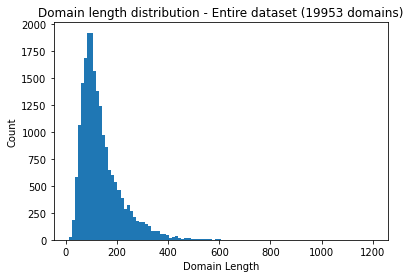

In [6]:
plt.hist(generated_domain_lengths.values(), bins=100)
plt.title('Domain length distribution - Entire dataset (19953 domains)')
plt.xlabel('Domain Length')
plt.ylabel('Count')
#plt.savefig('../../plots/domain_length_distribution_all.png', dpi=200);

### Segmentation based on Homologous superfamily

Following the instruction given in the AlphaFold paper, we want to ensure that all domains from a certain homologous superfamily are included in either Training, Validation or Test data set.

In [11]:
def make_barh(arr, ax, label, title='', fontsize=15, ticks=False, xlim=20000):
    vals, counts = np.unique(arr, return_counts=True)

    valscounts = np.array([vals, counts], dtype=np.int).T
    valscounts = valscounts[valscounts[:,1].argsort()][::-1] # sort by counts
    
    ax.barh(label, valscounts[0, 1])
    h = valscounts[0, 1]

    for i in range(1, len(vals)):
        ax.barh(label, valscounts[i, 1], left=h)
        h += valscounts[i, 1]

    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    if ticks == False:
        ax.set_xticks([])
    ax.set_title(title, fontsize=15)
    ax.set_xlim(0, xlim)

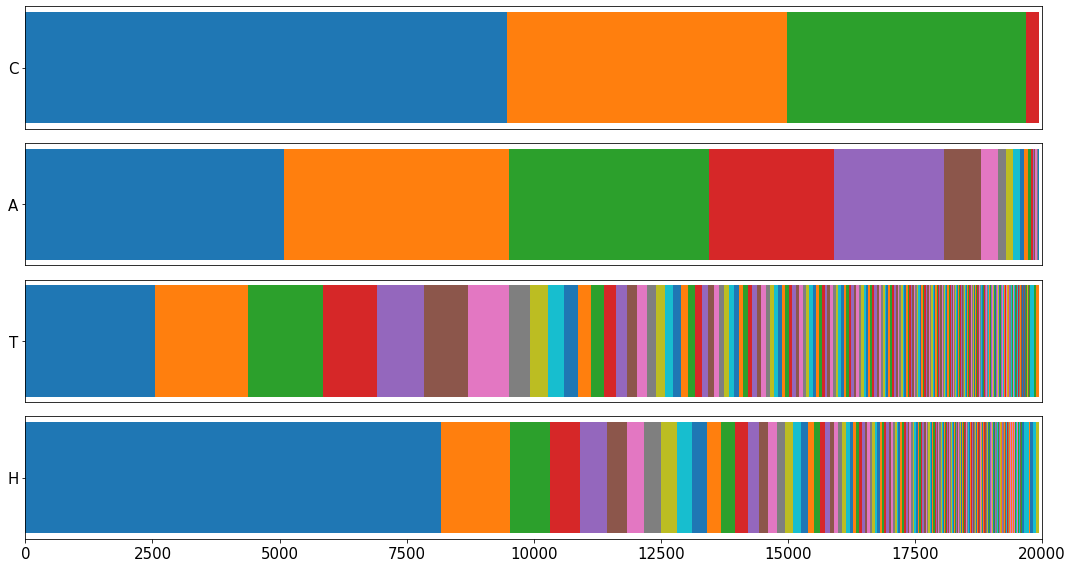

In [92]:
fig, ax = plt.subplots(4, 1, figsize=(15, 8))
for i, ch in enumerate(['C', 'A', 'T']):
    make_barh(cath_data[:, i+1], ax[i], ch, '', 15)
make_barh(cath_data[:, 4], ax[3], 'H', '', 15, True)
plt.tight_layout()
#plt.savefig('../../plots/cath_distributions.png', dpi=200)

## Generate Train, Test and Validation Sets

#### 1. Filter Homologous Superfamilies with more than `HOMOLOGOUS_SUPERFAMILY_CUTOFF` members. If this condition is satisfied then randomly pick that number of domains from that particular superfamily

In [19]:
homologous_superfamilies, counts = np.unique(cath_data[:, 4], return_counts=True)

In [20]:
indices_to_delete = []

for HS_ID in homologous_superfamilies[np.where(counts > HOMOLOGOUS_SUPERFAMILY_CUTOFF)[0]]:
    
    HS_ind = cath_data[cath_data[:, 4] == HS_ID][:, 0]
    
    pick_indices_to_delete = np.random.choice(HS_ind, HS_ind.shape[0] - HOMOLOGOUS_SUPERFAMILY_CUTOFF, replace=False)
    
    indices_to_delete.extend(list(pick_indices_to_delete))

In [21]:
cath_data_filtered = cath_data[np.setdiff1d(cath_data[:, 0], indices_to_delete)]

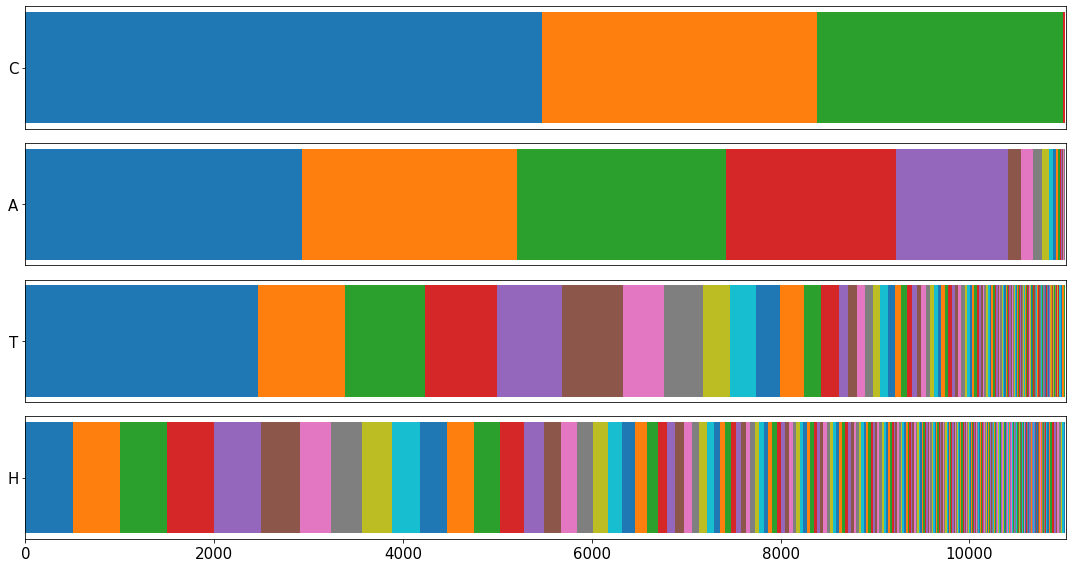

In [22]:
fig, ax = plt.subplots(4, 1, figsize=(15, 8))
for i, ch in enumerate(['C', 'A', 'T']):
    make_barh(cath_data_filtered[:, i+1], ax[i], ch, '', 15, xlim=11020)
make_barh(cath_data_filtered[:, 4], ax[3], 'H', '', 15, True, xlim=11020)
plt.tight_layout()
#plt.savefig('../../plots/cath_distributions_filtered.png', dpi=200)

#### 2. Create Train, Val and Test set, while keeping in mind that all members of one superfamily have to be inside on of the sets

In [23]:
homologous_superfamilies, counts = np.unique(cath_data_filtered[:, 4], return_counts=True)

##### 2.1 Pick families

In [24]:
np.random.seed(1618)

length = 0
families = []

# TEST
test_families = []

while length != TEST_SET_SIZE:
    
    ind = np.random.randint(len(counts))
    family, familysize = homologous_superfamilies[ind], counts[ind]
    
    if familysize < MAX_FAMILY_SIZE:
        if length + familysize <= TEST_SET_SIZE and family not in families:
            length += familysize
            families.append(family)
            test_families.append(family)


length = 0

# VALIDATION
validation_families = []

while length != VALIDATION_SET_SIZE:
    
    ind = np.random.randint(len(counts))
    family, familysize = homologous_superfamilies[ind], counts[ind]
    
    if familysize < MAX_FAMILY_SIZE:
        if length + familysize <= VALIDATION_SET_SIZE and family not in families:
            length += familysize
            families.append(family)
            validation_families.append(family)

##### 2.2 Create datasets

In [25]:
# TEST
test_data = cath_data_filtered[cath_data_filtered[:, 4] == test_families[0]]
for i in range(1, len(test_families)):
    test_data = np.concatenate((test_data, cath_data_filtered[cath_data_filtered[:, 4] == test_families[i]]))
    
# VALIDATION
validation_data = cath_data_filtered[cath_data_filtered[:, 4] == validation_families[0]]
for i in range(1, len(validation_families)):
    validation_data = np.concatenate((validation_data, cath_data_filtered[cath_data_filtered[:, 4] == validation_families[i]]))
    
# TRAIN
train_indices = np.setdiff1d(cath_data_filtered[:, 0], np.concatenate((test_data[:, 0], validation_data[:, 0])))
train_data = cath_data_filtered[[cath_data_filtered[i, 0] in train_indices for i in range(cath_data_filtered.shape[0])]]

**SANITY CHECK**

In [26]:
print(np.setdiff1d(test_data[:, 0], validation_data[:, 0]).shape[0] == test_data.shape[0])
print(np.setdiff1d(test_data[:, 0], train_data[:, 0]).shape[0] == test_data.shape[0])

print(np.setdiff1d(validation_data[:, 0], test_data[:, 0]).shape[0] == validation_data.shape[0])
print(np.setdiff1d(validation_data[:, 0], test_data[:, 0]).shape[0] == validation_data.shape[0])

print(np.setdiff1d(train_data[:, 0], validation_data[:, 0]).shape[0] == train_data.shape[0])
print(np.setdiff1d(train_data[:, 0], test_data[:, 0]).shape[0] == train_data.shape[0])

True
True
True
True
True
True


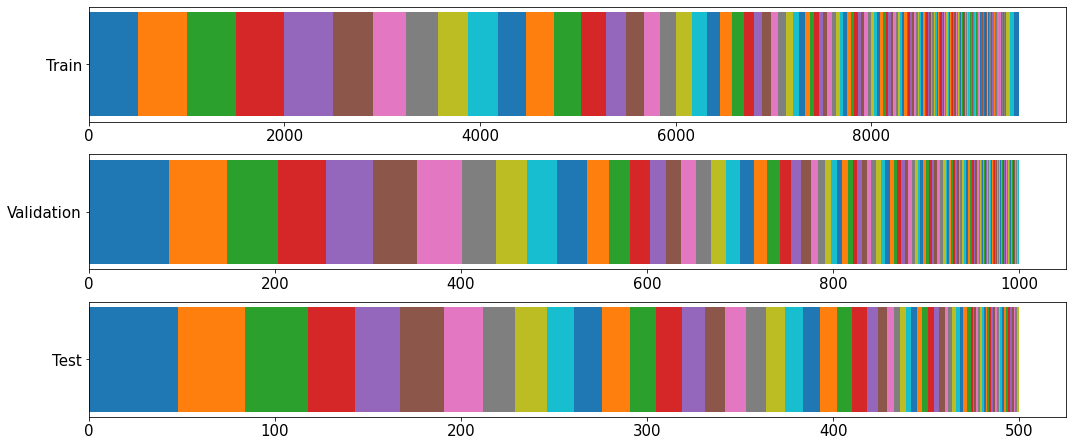

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6.3))
make_barh(train_data[:, 4], ax[0], 'Train', '', 15, True, xlim=None)
make_barh(validation_data[:, 4], ax[1], 'Validation', '', 15, True, xlim=None)
make_barh(test_data[:, 4], ax[2], 'Test', '', 15, True, xlim=None)
plt.tight_layout()
plt.savefig('../../plots/cath_distributions_trainvaltest.png', dpi=200)

In [28]:
# Test Domains
test_domains = cath_domains[test_data[:, 0]]
with open('../../data/our_input/test_domains.csv', 'w') as f:
    for i in test_domains:
        f.write(i + '\n')
        
# Validation Domains
validation_domains = cath_domains[validation_data[:, 0]]
with open('../../data/our_input/validation_domains.csv', 'w') as f:
    for i in validation_domains:
        f.write(i + '\n')

# Train Domains
train_domains = cath_domains[train_data[:, 0]]
with open('../../data/our_input/train_domains.csv', 'w') as f:
    for i in train_domains:
        f.write(i + '\n')

### Domain length Distributions

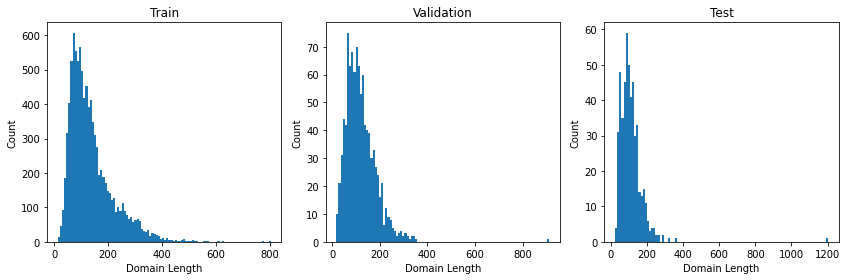

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
titles = ['Train', 'Validation', 'Test']
for i, domains in enumerate((train_domains, validation_domains, test_domains)):
    lengths = []
    for d in domains:
        lengths.append(generated_domain_lengths[d])
        
    ax[i].hist(lengths, bins=100)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Domain Length')
    ax[i].set_ylabel('Count')

plt.tight_layout()
plt.savefig('../../plots/trainvaltest_domain_length_distributions.png', dpi=200)

# DONE!!!